# Image Classification using CNNs
In the previous workbook we attempted to solve a problem classify Fashion items into 1 of 10 categories using the to Fashion MNIST dataset. 

The results were less accurate than we probably wanted so we are going to repeat the exercise but this time we will use a network based on Convolutions. This should yield much better results

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [25]:
def showSampleImages(image_data, image_labels, class_labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_data[i], cmap=plt.cm.binary)
        plt.xlabel(class_labels[image_labels[i]])
    plt.show()

def printSampleCnnIncorrectImages(source_data, image_labels, class_names, model):
  incorrects = np.nonzero(model.predict_classes(source_data).reshape((-1,)) != image_labels)
  
  plt.figure(figsize=(10,10))
  max_items = 25 if len(incorrects[0]) > 25 else len(incorrects[0])
  
  for i in range(max_items):
    incorrect_image_index = incorrects[0][i]
    incorrect_image_data = np.array([source_data[incorrect_image_index]])
    expected_class = class_names[image_labels[incorrect_image_index]]
    preds = model.predict_classes(incorrect_image_data)    
    predicted_class = class_names[model.predict_classes(incorrect_image_data)[0]]
    errorTitle = "Expected class: '%s'\nPredicted class: '%s'"%(expected_class, predicted_class)

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    #plt.imshow(image_data[incorrect_image_index], cmap=plt.cm.binary)
    plt.imshow(source_data[incorrect_image_index].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(errorTitle)
  plt.show()

def displayLossAndAccuracy(history):
  plt.plot(history.history['loss'], color='red', label='Loss')
  plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
  plt.legend()
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.show()

def printSampleIncorrectImages(image_data, image_labels, class_names, model):
    incorrects = np.nonzero(model.predict_classes(image_data).reshape((-1,)) != image_labels)
    
    plt.figure(figsize=(10,10))
    max_items = 25 if len(incorrects[0]) > 25 else len(incorrects[0])
    for i in range(max_items):
        incorrect_image_index = incorrects[0][i]
        incorrect_image_data = np.array([image_data[incorrect_image_index]])
        expected_class = class_names[image_labels[incorrect_image_index]]
        predicted_class = class_names[model.predict_classes(incorrect_image_data)[0]]
        errorTitle = "Expected class: '%s'\nPredicted class: '%s'"%(expected_class, predicted_class)
    
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.tight_layout()
        plt.imshow(image_data[incorrect_image_index], cmap=plt.cm.binary)
        plt.xlabel(errorTitle)
    plt.show()

def displayConfusionMatrix(expected, predicted):
  import seaborn as sn
  from sklearn.metrics import confusion_matrix

  confusion_matrix = confusion_matrix(y_true = expected, y_pred = predicted)
  plt.figure(figsize=(12,8))
  ax = plt.subplot()
  sn.heatmap(confusion_matrix, annot=True, ax = ax)
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix'); 

  plt.show()



def displayLayerActivations(cnn_model, image):
  import numpy as np
  from tensorflow.keras.preprocessing.image import img_to_array, load_img

  # Let's define a new Model that will take an image as input, and will output
  # intermediate representations for all layers in the previous model after
  # the first.
  successive_outputs = [layer.output for layer in cnn_model.layers[1:]]
  #visualization_model = Model(img_input, successive_outputs)
  visualization_model = tf.keras.models.Model(inputs = cnn_model.input,
                                              outputs = successive_outputs)
  
  # Let's run our image through our network, thus obtaining all
  # intermediate representations for this image.
  image = image.reshape(1,28,28,1)
  successive_feature_maps = visualization_model.predict(image)

  # These are the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]

  # Now let's display our representations
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
      # Just do this for the conv / maxpool layers, not the fully-connected layers
      n_features = feature_map.shape[-1]  # number of features in feature map
      # The feature map has shape (1, size, size, n_features)
      size = feature_map.shape[1]
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
      for i in range(n_features):
        # Postprocess the feature to make it visually palatable
        image = feature_map[0, :, :, i]
        image -= image.mean()
        image /= image.std()
        image *= 64
        image += 128
        image = np.clip(image, 0, 255).astype('uint8')
        # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = image 
      # Display the grid
      scale = 20. / n_features
      plt.figure(figsize=(scale * n_features, scale))
      plt.title(layer_name)
      plt.grid(False)
      #plt.imshow(display_grid, aspect='auto', cmap='viridis')
      plt.imshow(display_grid, aspect='auto', cmap=plt.cm.binary)
      

## Load the  Fashion MNIST dataset
We will now load the dataset and normalise the data as before

In [16]:
from tensorflow.keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()
# This is the list of labels for the classes
class_names = ["t-shirt", "trousers", "pullover", "dress", "coat",
           "sandle", "shirt", "sneaker", "bag", "boot"]

# Normalise the data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

Images from the Training dataset


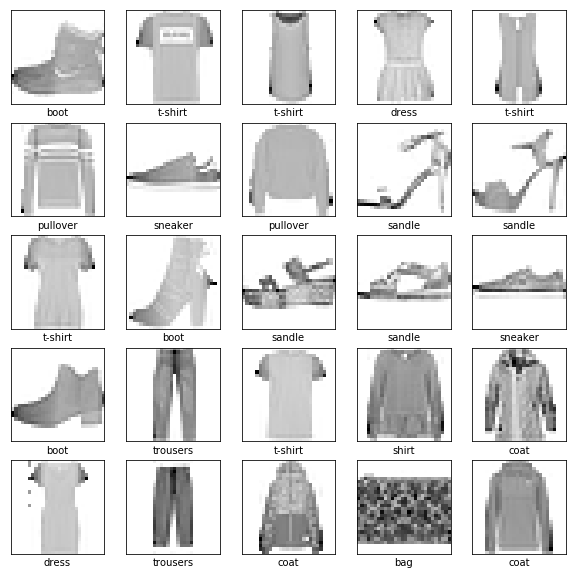

In [17]:
print("Images from the Training dataset")
showSampleImages(x_train, y_train, class_names)

## Introducing Convolution Layers
In the models we have been creating we take a 2-D image and flatten it into a single stream of values.

However when we flatten the input we "loose" some of the spacial information that is contained in the images (e.g. how one pixel or set of pixels relate to each other). With a single list of numbers, does not know how pixels relate to each other so it's harder to "learn" spacial information such as lines and patterns. 

This could be one of the reasons why we seem incapable of doing well on this task. 

To regain this spacial awareness we need a different types of layers to capture this information.
- Convolutional Layers
- Pooling Layers

### Understanding Convolution Layers
Convolutions are a technique from Image Processing that are applied to images to perform operations such as:
- sharpen an image
- Emphisise Veritical, Horizontal or diagonal lines
- Emphisise transitions form dark to light

In image processing we use specific Convolutions to perform the above operations, but in machine learning we want our model to learn it's own Convolutions from the images so that it can learn basic features (such as lines, shades etc.) and complex features (such as textures, head shapes etc.).

A convolution operations works on a filter and scans the image systematically. During _training_ the model is attempting to create a filter that describes some feature of the images it is presented. During _prediction_ the filter is used to detect these features in the image.

The following animaation (source https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) shows how Convolutions work.

<img src="https://cdn-images-1.medium.com/max/800/1*Fw-ehcNBR9byHtho-Rxbtw.gif" alt="Alt text that describes the graphic" title="Title text" height="400" width="400" />

Learning these convolutions allows our model to learn localised features such as perhaps, how do the positions of eyes relate to each other in an image.

This can be quite complex to implement but luckily _Keras_ has pre-implemented the Convolution layer so we can simply add this to our model like we have done with the __Dense__ layers

We can create Convolution in Keras using:

`tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(3, 3), activation='relu')`

Where:
- __filters__ is the number of convolution units we want such as 32, 64, 128, 256...
    - We can have any number of filters but these are typical values
- __kernel_size__ is the size of the grid we want to use such as 1x1, 2x2, 3x3 or 5x5
    - The grid can be of any size but these are fairly typical values.
- __padding__ defines the way that we deal with margins. 
     - _same_ means we produce an output of the same dimention as the input by extending the image with 0 value cells.
     - _valid_ means we will only process cells wholly within the input - the output is a smaller that the input. The animation above shows _valid_ padding.
 
Full details of the Conv2D layer can be found at https://keras.io/layers/convolutional/

### Understanding Pooling layers
Pooling layers also systematically scan the image using a filter (_kernel_) but instead of learning some property, they perform some mathematical operations on the data under the grid. These operations can be:
- Take the _maximum_ value of the data under the grid. This is known as __Max Pooling__
- Take the _minimum_ value of the data under the grid. This is known as __Min Pooling__
- Take the _average_ value of the data under the grid. This is known as __Average Pooling__

This has the effect of reducing variance and reducing the computational complexity while extracting salient features.

A good article on Pooling is at https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9

Again Keras makes adding Pooling layers very easy for use:

`tf.keras.layers.MaxPooling2D(pool_size=2, stride=2)
tf.keras.layers.AveragePooling2D(pool_size=2, stride=2)
tf.keras.layers.MinPooling2D(pool_size=2, stride=2)`

Where:
- __pool_size__ is the size of the grid (in the above cases 2x2)
    - We can have non-square pool_sizes such as (1, 3)
- __strides__ is the size of the step taken for each pooling operation (in the above cases we step by 2 places each pooling operation)

Full details of Keras Pooling layers can be found at https://keras.io/layers/pooling/

## Let's create a Convolutional Neural Netwok
We will now attempt to solve our image classificaiton problem using a Convolutional Neural Network (CNN) and see if we can improve on our previous accuracy score.

In this exercise we will create a small CNN. To get you started we will provide you with the input and output layers and one hidden layer. You will take this starter code and build your own network.

### Exercise
Work in your groups to decide what network archiecture you will use and each train a different network to compare the results.

Some options include:
- Adding additional Convolution layers with different numbers of filters and kernel sizes
- Adding different pooling layers and kernel sizes

__Notes:__ 
- when using convolutions it is typical that the number of filters increases as you go deeper into the network so consider patterns such as 32 -> 64 - > 128 rather than decreasing the number of filters.
- The more filters you choose the longer the training will take so try not to be too extravagent (at least during the workshop!)

In [20]:
model = tf.keras.models.Sequential()

# Input layer
# TODO: Specify how many filters you want in the first layer
model.add(tf.keras.layers.Conv2D(filters=None, kernel_size=(3, 3), 
                                     activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Hidden Layer 
# TODO: Specify how many filters you want in the hidden layer 
#        Specify the size of the kernel - for example (3,3)
model.add(tf.keras.layers.Conv2D(filters=None, padding='same', kernel_size=(None, None), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# TODO: Optionally add one or more hidden layers by copying the above 2 lines of code
#       and altering the number of filters, kernal and pool_sizes

# TODO: Optionally add a Dropout layer after some of the Conv2D layers (but before Pooling layers)
# You can add a dropout layer using:
#       model.add(tf.keras.layers.Dropout(0.25))

# Output layers: 
#     here we prepare the outputs for feeding into a Dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

# Output Layer - we have 10 classes so need 10 nodes
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

## Creating a Channel dimention for our data
When working with CNNs we need to to include a channel in our data - we will see when we work with colour images why this is needed. 

Since we images are greyscale, they only have 1 channel which is the pixel value itself. We are not going to add any new data but just reshape our training data to include a channel.

In [21]:
# Just a bit more data prep to work with Convoltions
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

## Train our model

In [22]:
# Train the model
num_epochs = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, epochs=num_epochs, validation_split = 0.2, 
                    callbacks=[early_stop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 132s 3ms/sample - loss: 0.4458 - accuracy: 0.8351 - val_loss: 0.3418 - val_accuracy: 0.8752
Epoch 2/2
48000/48000 [==============================] - 144s 3ms/sample - loss: 0.2914 - accuracy: 0.8921 - val_loss: 0.2712 - val_accuracy: 0.9003


## Evaluate your model

In [23]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print ("Validation Loss:", val_loss)
print ("Validation Accuracy:", val_acc)

10000/10000 [==============================] - 6s 619us/sample - loss: 0.2880 - accuracy: 0.8921 - l
Validation Loss: 0.28803643597364426
Validation Accuracy: 0.8921


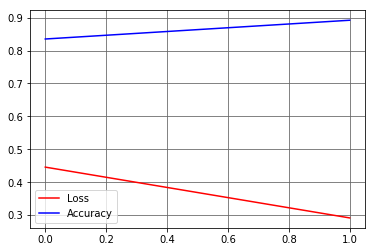

In [26]:
# summarize history for loss and accuracty across epochs
displayLossAndAccuracy(history)

0 = t-shirt
1 = trousers
2 = pullover
3 = dress
4 = coat
5 = sandle
6 = shirt
7 = sneaker
8 = bag
9 = boot


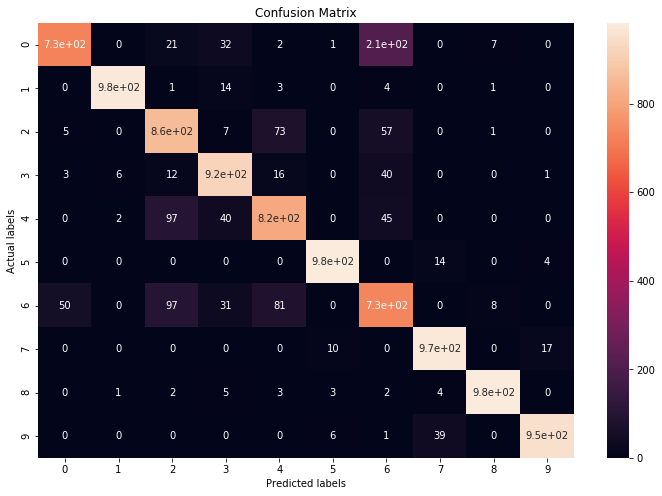

In [27]:
# Produce the Confusion Matrix
test_predictions = model.predict_classes(x_test)
for i, label in enumerate(class_names):
    print("{} = {}".format(i, label))
displayConfusionMatrix(y_test, test_predictions)

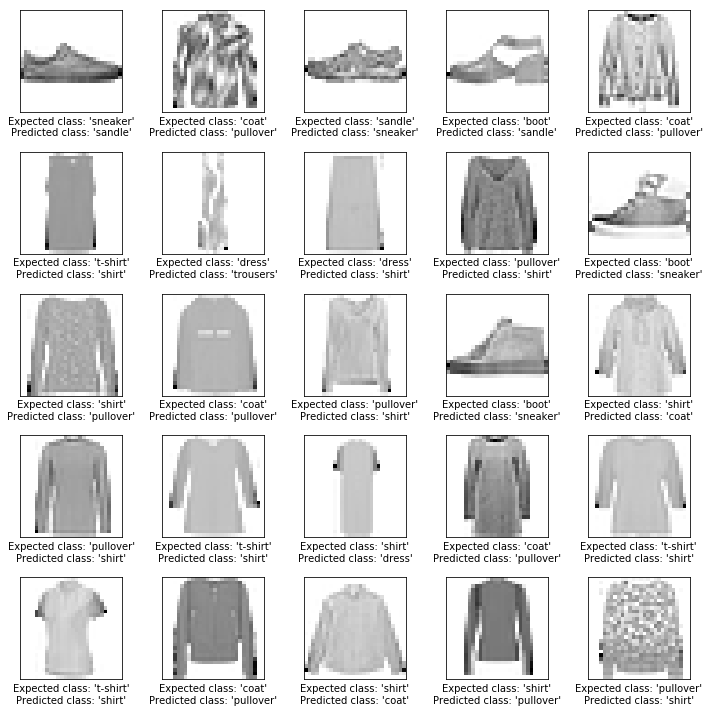

In [28]:
# Display some of the incorrectly classified images
printSampleCnnIncorrectImages(x_test, y_test, class_names, model)

### Exercise
In groups, disucss the following:
- Did the Convolution Model perform better than the Dense Layer Model? If so in what ways?
- Did using the Convolution Model change what type of _Confusions_ the model had?
- Do you think training the CNN for longer would produce better results?
- How well did the CNN generalise to the unseen Test Data?

# Key Observations
The following are key observations to note before we move on
1. The relationship between local features can be important and so we need ways to capture this information to enable better learning.
    - In this workbook we looked at the use of Convolational Layers which can be used to capture relationships between local features. 
    - Other types of layers exist that have different properties that are useful in different types of data.
2. Models can have good accuracy during training but don't generalise well - this is known as Overfitting.
    - there are techniques that we can use to overcome this (such as adding Dropown layers) but this is more advanced that we want to cover in this workshop.
3. The more complex the taks the more involved the network architecture can become.
    - We will specifically address this in the next lesson.